In [1]:
# Install Prophet if not already available
!pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import statsmodels.api as sm

In [2]:
# Create a dummy dataset for 2 years of daily sales
dates = pd.date_range(start='2024-01-01', periods=730, freq='D')
np.random.seed(42)

# Base demand with seasonality
base_demand = 100 + 20 * np.sin(np.arange(730) * (2 * np.pi / 365))
prices = np.random.uniform(50, 100, size=730)
# Demand drops as price increases (Elasticity)
quantity_sold = base_demand - 0.5 * prices + np.random.normal(0, 5, 730)

df = pd.DataFrame({'ds': dates, 'y': quantity_sold, 'price': prices})
df.head()


,ds,y,price
0,2024-01-01,67.608758,68.727006
1,2024-01-02,49.471487,97.535715
2,2024-01-03,58.837458,86.599697
3,2024-01-04,71.442935,79.932924
4,2024-01-05,76.831206,57.800932


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


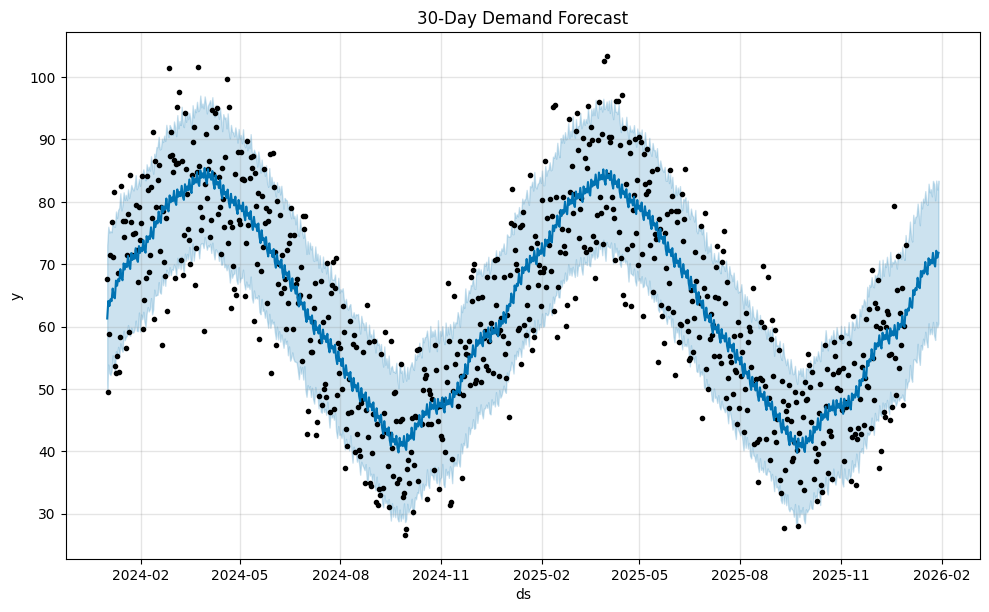

In [3]:
# Initialize and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df[['ds', 'y']])

# Predict the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast)
plt.title("30-Day Demand Forecast")
plt.show()

In [4]:
# Log-transform for Elasticity
df['log_price'] = np.log(df['price'])
df['log_qty'] = np.log(df['y'].clip(lower=1)) # clip to avoid log(0)

X = sm.add_constant(df['log_price'])
results = sm.OLS(df['log_qty'], X).fit()

elasticity = results.params['log_price']
print(f"Price Elasticity: {elasticity:.2f}")

Price Elasticity: -0.56


In [5]:
def dynamic_pricing_engine(predicted_demand, current_stock, base_price, elasticity):
    # Scenario: Low Stock + High Demand -> Increase Price
    if predicted_demand > current_stock:
        markup = 0.10 # 10% increase
        return base_price * (1 + markup)

    # Scenario: High Stock + Low Demand -> Decrease Price (Markdown)
    elif predicted_demand < (current_stock * 0.5):
        # Use elasticity to justify a deeper discount
        discount = 0.15 if elasticity < -1 else 0.05
        return base_price * (1 - discount)

    return base_price

# Example Test
suggested = dynamic_pricing_engine(predicted_demand=150, current_stock=100, base_price=80, elasticity=elasticity)
print(f"Suggested Dynamic Price: ${suggested:.2f}")

Suggested Dynamic Price: $88.00
